# MultiOmics RNA + ATAC for Chao dataset emphasis on OL population (MORNAATACCOL) technical documentation
## Multiomics RNAseq & ATACseq on EAE model

<hr>

**This notebook is the following of MORNAATACCOL 16 notebook**

<hr>

In [ ]:
#Memory needed for a full run : 256Gb

In [ ]:
#Early1               = P21208_1003_EAE_ARC
#PeakCtrl2            = P21208_1004_EAE_ARC
#Peak2                = P21208_1005_EAE_ARC
#LateCtrl1            = MORNAATACC_1002 (P21520_1002)
#Late1                = MORNAATACC_1003 (P21520_1003)
#Early2               = P23605_1001
#EarlyCtrl2           = P23605_1002
#Peak3                = P23605_1003
#PeakCtrl3            = P23605_1004
#EarlyCtrl3           = P24115_1001
#EarlyFemale3         = P24115_1002
#EarlyMale3           = P24115_1003
#Late2                = P25316_1001
#LateCtrl2            = P25316_1002
#Late3                = P25316_1003
#LateCtrl3            = P25316_1004
#PeakMale4            = P27208_1001
#PeakFemale4          = P27208_1002
#LateMale4            = P27208_1003
#LateFemale4          = P27208_1004
#Naive1               = P26203_1003
#Naive2               = P26203_1004
#Peak5                = P29557_1001
#Late5                = P29557_1002
#Naive3               = P29557_1004
#EarlyCtrl4           = P29557_1005
#EarlyCtrlMale5       = P29557_1006
#EarlyCtrlFemale5     = P29557_1007
#Early4               = P29557_1008
#EarlyMale5           = P29557_1009
#EarlyFemale5         = P29557_1010

## 0. Environment status

In [1]:
%use

Subkernel,Kernel Name,Language,Language Module,Interpreter
Bash,bash,bash,sos_bash,/usr/bin/python3
Bash,calysto_bash,bash,sos_bash,python
Python3,python3,python,sos_python,python
R,ir,R,sos_r,/usr/lib/R/bin/R
SoS,sos,sos,,/usr/bin/python3


In [2]:
lsb_release -a

In [ ]:
lscpu

In [ ]:
grep MemTotal /proc/meminfo | awk '{print $2 / 1024}'

In [ ]:
apt list --installed

In [ ]:
pip list

In [ ]:
jupyter --version

In [ ]:
#conda env export -n jupyter

## 1. Loading environments

### 1.1 R Packages

In [ ]:
library(Seurat)
library(Signac)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(dplyr)
library(stringr)
library(harmony)
library(clustree)
library(data.table)
library(biomaRt)
library(cowplot)
library(randomForest)
library(ggplot2)
library(caret)
library(tidyverse)
library(pheatmap)
library(grid)
library(gridExtra)
library(biovizBase)
library(ggrepel)
library(viridis)
library(reshape2)
library(hues)
library(clusterProfiler)
library(org.Mm.eg.db)
library(ggnewscale)
library(scales)

#conda dependencies trouble
library(enrichplot)
library(ReactomePA)

library(textclean)
library(mclust)

library(muscat)
library(SingleCellExperiment)
library(magrittr)
library(plyr)
library(scater)
library(cowplot)
library(UpSetR)
library(limma)
library(Matrix.utils)
library(purrr)
library(DESeq2)
library(EnhancedVolcano)

#ATAC analysis Signac
library(JASPAR2020)
library(TFBSTools)

library(cicero)
library(SeuratWrappers)

In [2]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SeuratWrappers_0.3.5               cicero_1.3.9                      
 [3] Gviz_1.44.2                        monocle3_1.3.7                    
 [5] TFBSTools_1.40.0                   JASPAR2020_0.99.10                
 [7] EnhancedVolcano_1.20.0             DESeq2_1.42.1         

### 1.2 Functions

In [3]:
PrctCellExpringGene <- function(object, genes, group.by = "all"){
    if(group.by == "all"){
        prct = unlist(lapply(genes,calc_helper, object=object))
        result = data.frame(Markers = genes, Cell_proportion = prct)
        return(result)
    }

    else{        
        list = SplitObject(object, group.by)
        factors = names(list)

        results = lapply(list, PrctCellExpringGene, genes=genes)
        for(i in 1:length(factors)){
        results[[i]]$Feature = factors[i]
        }
        combined = do.call("rbind", results)
        return(combined)
    }
}

calc_helper <- function(object,genes){
    counts = object[['RNA']]@counts
    ncells = ncol(counts)
    if(genes %in% row.names(counts)){
    sum(counts[genes,]>0)/ncells
    }else{return(NA)}
}

NbCellExpringGene <- function(object, genes, group.by = "all"){
    if(group.by == "all"){
        nb = unlist(lapply(genes,calc_helper_nb, object=object))
        result = data.frame(Markers = genes, Cell_nb = nb)
        return(result)
    }

    else{        
        list = SplitObject(object, group.by)
        factors = names(list)

        results = lapply(list, NbCellExpringGene, genes=genes)
        for(i in 1:length(factors)){
        results[[i]]$Feature = factors[i]
        }
        combined = do.call("rbind", results)
        return(combined)
    }
}

calc_helper_nb <- function(object,genes){
    counts = object[['RNA']]@counts
    if(genes %in% row.names(counts)){
    length(counts[genes,][counts[genes,] > 0])
    }else{return(NA)}
}

DoMultiBarHeatmap <- function (object, features = NULL, cells = NULL, group.by = "ident", additional.group.by = NULL, additional.group.sort.by = NULL,  cols.use = NULL, group.bar = TRUE, disp.min = -2.5, disp.max = NULL, layer = "scale.data", assay = NULL, label = TRUE, size = 5.5, hjust = 0, angle = 45, raster = TRUE, draw.lines = TRUE, lines.width = NULL, group.bar.height = 0.02, combine = TRUE){

  cells <- cells %||% colnames(x = object)
  if (is.numeric(x = cells)) {
    cells <- colnames(x = object)[cells]
  }
  assay <- assay %||% DefaultAssay(object = object)
  DefaultAssay(object = object) <- assay
  features <- features %||% VariableFeatures(object = object)
  ## Why reverse???
  features <- rev(x = unique(x = features))
  disp.max <- disp.max %||% ifelse(test = layer == "scale.data", yes = 2.5, no = 6)
  possible.features <- rownames(x = LayerData(object = object, assay = assay, layer = layer))
  if (any(!features %in% possible.features)) {
    bad.features <- features[!features %in% possible.features]
    features <- features[features %in% possible.features]
    if (length(x = features) == 0) {
      stop("No requested features found in the ", layer,
      " slot for the ", assay, " assay.")
    }
    warning("The following features were omitted as they were not found in the ", layer, " slot for the ", assay, " assay: ", paste(bad.features, collapse = ", "))
  }

  if (!is.null(additional.group.sort.by)) {
    if (any(!additional.group.sort.by %in% additional.group.by)) {
      bad.sorts <- additional.group.sort.by[!additional.group.sort.by %in% additional.group.by]
      additional.group.sort.by <- additional.group.sort.by[additional.group.sort.by %in% additional.group.by]
      if (length(x = bad.sorts) > 0) {
        warning("The following additional sorts were omitted as they were not a subset of additional.group.by : ",
        paste(bad.sorts, collapse = ", "))
      }
    }
  }

  data <- as.data.frame(x = as.matrix(x = t(x = LayerData(object = object, assay = assay, layer = layer)[features, cells, drop = FALSE])))

  object <- suppressMessages(expr = StashIdent(object = object, save.name = "ident"))
  group.by <- group.by %||% "ident"
  groups.use <- object[[c(group.by, additional.group.by[!additional.group.by %in% group.by])]][cells, , drop = FALSE]
  plots <- list()
  for (i in group.by) {
    data.group <- data
    if (!is.null(additional.group.by)) {
      additional.group.use <- additional.group.by[additional.group.by!=i]
      if (!is.null(additional.group.sort.by)){
        additional.sort.use = additional.group.sort.by[additional.group.sort.by != i]
      } else {
        additional.sort.use = NULL
      }
    } else {
      additional.group.use = NULL
      additional.sort.use = NULL
    }

    group.use <- groups.use[, c(i, additional.group.use), drop = FALSE]

    for(colname in colnames(group.use)){
      if (!is.factor(x = group.use[[colname]])) {
        group.use[[colname]] <- factor(x = group.use[[colname]])
      }
    }

    if (draw.lines) {
      lines.width <- lines.width %||% ceiling(x = nrow(x = data.group) * 0.0025)
      placeholder.cells <- sapply(X = 1:(length(x = levels(x = group.use[[i]])) * lines.width), FUN = function(x) {
        return(Seurat:::RandomName(length = 20))
      })
      placeholder.groups <- data.frame(rep(x = levels(x = group.use[[i]]), times = lines.width))
      group.levels <- list()
      group.levels[[i]] = levels(x = group.use[[i]])
      for (j in additional.group.use) {
        group.levels[[j]] <- levels(x = group.use[[j]])
        placeholder.groups[[j]] = NA
      }

      colnames(placeholder.groups) <- colnames(group.use)
      rownames(placeholder.groups) <- placeholder.cells

      group.use <- sapply(group.use, as.vector)
      rownames(x = group.use) <- cells

      group.use <- rbind(group.use, placeholder.groups)

      for (j in names(group.levels)) {
        group.use[[j]] <- factor(x = group.use[[j]], levels = group.levels[[j]])
      }

      na.data.group <- matrix(data = NA, nrow = length(x = placeholder.cells), ncol = ncol(x = data.group), dimnames = list(placeholder.cells, colnames(x = data.group)))
      data.group <- rbind(data.group, na.data.group)
    }

    order_expr <- paste0('order(', paste(c(i, additional.sort.use), collapse=','), ')')
    group.use = with(group.use, group.use[eval(parse(text=order_expr)), , drop=F])

    plot <- Seurat:::SingleRasterMap(data = data.group, raster = raster, disp.min = disp.min, disp.max = disp.max, feature.order = features, cell.order = rownames(x = group.use), group.by = group.use[[i]])

    if (group.bar) {
      pbuild <- ggplot_build(plot = plot)
      group.use2 <- group.use
      cols <- list()
      na.group <- Seurat:::RandomName(length = 20)
      for (colname in rev(x = colnames(group.use2))) {
        if (colname == i) {
          colid = paste0('Identity (', colname, ')')
        } else {
          colid = colname
        }

        # Default
        cols[[colname]] <- c(scales::hue_pal()(length(x = levels(x = group.use[[colname]]))))

        #Overwrite if better value is provided
        if (!is.null(cols.use[[colname]])) {
          req_length = length(x = levels(group.use))
          if (length(cols.use[[colname]]) < req_length){
            warning("Cannot use provided colors for ", colname, " since there aren't enough colors.")
          } else {
            if (!is.null(names(cols.use[[colname]]))) {
              if (all(levels(group.use[[colname]]) %in% names(cols.use[[colname]]))) {
                cols[[colname]] <- as.vector(cols.use[[colname]][levels(group.use[[colname]])])
              } else {
                warning("Cannot use provided colors for ", colname, " since all levels (", paste(levels(group.use[[colname]]), collapse=","), ") are not represented.")
              }
            } else {
              cols[[colname]] <- as.vector(cols.use[[colname]])[c(1:length(x = levels(x = group.use[[colname]])))]
            }
          }
        }

        # Add white if there's lines
        if (draw.lines) {
          levels(x = group.use2[[colname]]) <- c(levels(x = group.use2[[colname]]), na.group)
          group.use2[placeholder.cells, colname] <- na.group
          cols[[colname]] <- c(cols[[colname]], "#FFFFFF")
        }
        names(x = cols[[colname]]) <- levels(x = group.use2[[colname]])

        y.range <- diff(x = pbuild$layout$panel_params[[1]]$y.range)
        y.pos <- max(pbuild$layout$panel_params[[1]]$y.range) + y.range * 0.015
        y.max <- y.pos + group.bar.height * y.range
        pbuild$layout$panel_params[[1]]$y.range <- c(pbuild$layout$panel_params[[1]]$y.range[1], y.max)

        plot <- suppressMessages(plot +
          annotation_raster(raster = t(x = cols[[colname]][group.use2[[colname]]]),  xmin = -Inf, xmax = Inf, ymin = y.pos, ymax = y.max) +
          annotation_custom(grob = grid::textGrob(label = colid, hjust = 0, gp = gpar(cex = 0.75)), ymin = mean(c(y.pos, y.max)), ymax = mean(c(y.pos, y.max)), xmin = Inf, xmax = Inf) +
          coord_cartesian(ylim = c(0, y.max), clip = "off")
        )


        if ((colname == i) && label) {
          x.max <- max(pbuild$layout$panel_params[[1]]$x.range)
          x.divs <- pbuild$layout$panel_params[[1]]$x.major %||% pbuild$layout$panel_params[[1]]$x$break_positions()
          group.use$x <- x.divs

          label.x.pos <- tapply(X = group.use$x, INDEX = group.use[[colname]], FUN = median) * x.max
          label.x.pos <- data.frame(group = names(x = label.x.pos), label.x.pos)
          plot <- plot + geom_text(stat = "identity", data = label.x.pos, aes_string(label = "group", x = "label.x.pos"), y = y.max + y.max *  0.03 * 0.5, angle = angle, hjust = hjust, size = size)
          plot <- suppressMessages(plot + coord_cartesian(ylim = c(0, y.max + y.max * 0.002 * max(nchar(x = levels(x = group.use[[colname]]))) * size), clip = "off"))
        }
      }
    }
    plot <- plot + theme(line = element_blank())
    plots[[i]] <- plot
  }
  if (combine) {
    plots <- CombinePlots(plots = plots)
  }
  return(plots)
}


#####################################################
# Function for getting the marker peaks from the Seurat
# object, based on the current ident
#####################################################
getMarkerPeaks <- function(obj, doublets, n_peaks = 100, min_cells = 200){

  n_clusters = length(unique(as.vector(Idents(obj))))
  
  cells <- Cells(obj)
  
  # remove the doublet cells for better marker peaks
  obj <- subset(obj, cells = cells[!cells %in% doublets])
  
  obj@assays$ATAC@data@x <- obj@assays$ATAC@counts@x
  
  # default preporcessing o Signac applied
  obj <- RunTFIDF(obj, verbose = F)
  obj <- FindTopFeatures(obj, min.cutoff = NULL, verbose = F)
  obj <- RunSVD(
    object = obj,
    reduction.key = 'SVD_',
    reduction.name = 'svd',
    seed.use = 1,
    verbose = F
  )
  
  # get the marker peaks between all clusters
  da_peaks <- FindAllMarkers(
    object = obj,
    slot = "data",
    min.pct = 0.1,
    only.pos = TRUE,
    test.use = 'LR',
    min.cells.group = min_cells,
    verbose = F
  )
  
  # only keep the significant peaks
  metadata = lapply(unique(da_peaks$cluster), function(x){
    return(data.frame(da_peaks[da_peaks$p_val_adj < 0.05 & da_peaks$cluster == x,]))
  })
  
  names(metadata) <- paste0("Cluster_", unique(da_peaks$cluster))
  
  rm(da_peaks)
  
  meta_peaks = data.frame()
  
  for (i in names(metadata)) {
    
    cur_meta = data.frame(metadata[[i]])
    cur_meta$peaks = row.names(metadata[[i]])
    cur_meta$cluster = i
    row.names(cur_meta) = c()
    
    meta_peaks = rbind(meta_peaks, cur_meta)
    
    rm(cur_meta)
    
  }
  
  # sort the peaks based on the fold changes and signifigance, choose ones with high FC first
  meta_peaks = meta_peaks[order(meta_peaks$avg_logFC, -meta_peaks$p_val_adj, decreasing = T),]
  
  marker_peaks_set = data.frame(matrix(ncol=2,nrow=0, dimnames=list(NULL, c("gene", "cluster"))))
  
  # extract 100 marker peaks for each cluster
  while(nrow(marker_peaks_set) < n_peaks*n_clusters) {
    
    temp = meta_peaks[1, c("gene", "cluster")]
    
    marker_peaks_set = rbind(marker_peaks_set, temp)
    
    meta_peaks = meta_peaks[which(meta_peaks$gene != temp$gene),]
    
    if(length(which(marker_peaks_set$cluster == temp$cluster)) == n_peaks){
      meta_peaks = meta_peaks[which(meta_peaks$cluster != temp$cluster),]
    }
    
    rm(temp)
  }
  
  marker_peaks_set = marker_peaks_set[!is.na(marker_peaks_set$gene),]
  
  marker_peaks_set$cluster= factor(marker_peaks_set$cluster, levels = str_sort(unique(marker_peaks_set$cluster), numeric = T))
  marker_peaks_set = marker_peaks_set[order(marker_peaks_set$cluster),]
  
  rm(meta_peaks)
  
  colnames(marker_peaks_set)[1]<- "peaks"
  
  return(marker_peaks_set)
}

############################################
# get the readcount distribution profile for
# the singlet cells of every cluster
############################################
annotateDoublets <- function(obj, marker_peaks, doublets, k = 15){

  # get the read count distributions on the cluster specific marker peaks for all of the cells
  cell.values <- getCellValues(obj, cells = Cells(obj), marker_peaks_set = marker_peaks, doublets = doublets, k = k)
  
  #get the profile for the singlet cells of each cluster
  singlet.profile <- getProfiles(cell.values)
 
  # just annotate the doublets
  doublets <- cell.values %>% 
    subset(doublet == "doublet")
  
  clusters <- doublets %>% dplyr::select(starts_with("Cluster_")) %>% colnames()
  
  # look at every cluster in the data
  a.class <- lapply(clusters, function(clus){
    
    # just select the doublets that have the current cluster
    # as its most dominant cluster
    t.doublets <- doublets %>%
      subset(a.homotypic == clus, select = clusters)
    
    # get the profile of the current cluster
    t.profile <- singlet.profile[,clus]
    
    # calculate the distance of doublet cell distributions to
    # the profile of the current cluster
    t.dist <- apply(t.doublets, 1, function(cell){
      return(dist(rbind(cell, t.profile)))
    })
    
    # fit a GMM using the mclust package with no class limitations
    fit <- Mclust(t.dist, verbose = F)
    t.class <- fit$classification
    
    t.doublets$dist <- t.dist[rownames(t.doublets)]
    t.doublets$class <- t.class[rownames(t.doublets)]
    t.doublets$max.class <- names(which.max(fit[["parameters"]][["mean"]]))
    t.doublets$num.class <- length(unique(fit$classification))
    return(t.doublets[,c("dist", "class", "max.class", "num.class")])
  }) %>% bind_rows()
  
  doublets$class <- a.class[rownames(doublets),"class"]
  doublets$max.class <- a.class[rownames(doublets),"max.class"]
  doublets$num.class <- a.class[rownames(doublets),"num.class"]
  
  doublets <- lapply(rownames(doublets), function(cell){
    probs <- doublets[cell, clusters]
    
    # only classify the doublets that belong to the final class 
    # doublets[cell,"type"] <- ifelse(doublets[cell,"class"]== doublets[cell,"max.class"], "heterotypic", "homotypic")
    doublets[cell,"d.type"] <- ifelse(doublets[cell,"class"]== doublets[cell,"max.class"] & doublets[cell,"num.class"] > 1,
                                    "heterotypic", "homotypic")
    
    # report the top clusters based on type of the doublet; if homotypic just one, if heterotypic top 2 clusters
    doublets[cell, "d.annotation"] <- ifelse(doublets[cell,"d.type"] == "homotypic",
                                             names(probs)[order(probs, decreasing = T)[1]],
                                             paste(sort(names(probs)[order(probs, decreasing = T)[1:2]]), collapse = ".")) 
    
    return(doublets[cell,!(colnames(doublets) %in% c("a.heterotypic", "a.homotypic", "ident", "class", "max.class","num.class")), drop = FALSE])
  }) %>% bind_rows()

  return(doublets)
}

#####################################################
# Function to get the ditsribution of read counts on
# the marker peaks of clusters
#####################################################
getReadCountDistributions <- function(marker_peaks, read_counts){
  
  t_read_counts = data.frame(merge(marker_peaks, 100*read_counts, by.x = "peaks", by.y = 0, sort = F))
  names(t_read_counts) <- sub("^X", "", names(t_read_counts))
  t_read_counts$ids = unclass(t_read_counts$cluster)
  
  probs = matrix(nrow = ncol(read_counts), ncol = length(unique(t_read_counts$cluster)))
  
  row.names(probs) <- colnames(read_counts)
  colnames(probs) <- unique(t_read_counts$cluster)
  
  for (i in 1:nrow(probs)) {
    density_data = vector()
    
    for(j in 1:nrow(t_read_counts))
      density_data = c(density_data, rep(t_read_counts$ids[j], t_read_counts[j,row.names(probs)[i]]))
    
    for(j in 1:ncol(probs)){
      if(j==1)
        probs[i,j] = ecdf(density_data)(j)
      else
        probs[i,j] = (ecdf(density_data)(j) - ecdf(density_data)((j-1)))
    }
    
  }
  
  return(data.frame(probs))
}

#####################################################
# Function to plot the read count distributions of
# the given cells
#####################################################
plotReadCountDistributions <- function(probs, folder_path){
  
  if(!dir.exists(folder_path))
    dir.create(folder_path)
  
  sapply(rownames(probs), function(x){long_probs = gather(as.data.frame(bind_rows(probs[x,])), cell_type, probability, factor_key = TRUE)
  ggplot(data=long_probs, aes(x=cell_type, y=probability)) +
    geom_col() +
    theme(axis.text.x = element_text(angle = 90)) +
    ggtitle(x) + xlab("Cluster") + ylab("Score") + ylim(0,1) +
    ggsave(filename = paste0(folder_path, "/Probs_", x, ".pdf"))})
  
}

#####################################################
# Function to add read count distributions for the 
# cells in the provided in te Seurat object with the
# provided marker peaks
#####################################################
getCellValues <- function(obj, cells, marker_peaks_set, doublets, k = 15){
  
  obj@assays$ATAC@data@x <- obj@assays$ATAC@counts@x
  
  obj <- RunTFIDF(obj, verbose = F)
  obj <- FindTopFeatures(obj, min.cutoff = NULL, verbose = F)
  obj <- RunSVD(
    object = obj,
    reduction.key = 'SVD_',
    reduction.name = 'svd',
    seed.use = 1,
    verbose = F
  )
  
  # get the neighbor graph of the cells for aggregation
  obj <- FindNeighbors(obj, reduction = "svd", dims = 1:50, k.param = k+1, verbose = F)
  
  cell_annotations <- lapply(cells, function(cell){
    
    # extract the k neighbors of the current cell
    neighbors <- names(obj@graphs$ATAC_nn[cell, obj@graphs$ATAC_nn[cell,] > 0])
    
    # extract the reads for the cell and its k-nearest neighbors
    reads <- Matrix::as.matrix(subset(obj, cells = neighbors, features = marker_peaks_set$peaks)@assays[["ATAC"]]@counts)
    
    no_clusters <- length(unique(marker_peaks_set$cluster))
    
    results = data.frame(matrix(nrow = 0, ncol = no_clusters+1)) %>%
      `colnames<-`(value = c("cell_id", as.character(unique(marker_peaks_set$cluster))))
    
    results[cell,"cell_id"] = cell
    
    # aggregate the reads for the cell by taking the mean with k-nn
    reads <- data.frame(apply(reads, 1, mean)) %>%
      `colnames<-`(value = cell)
    
    if(colSums(reads) == 0){
      results[,-1] <- 0
      
      results[cell, "a.heterotypic"] <- NA
      results[cell, "a.homotypic"] <- NA
        
      return(results)
    }
    
    # calculate the read count distribution of the cell on the marker peaks
    doublet_probs <- reads %>%
      getReadCountDistributions(marker_peaks_set,.) %>% data.frame()
    
    results[cell, colnames(doublet_probs)] <- doublet_probs
    
    # report the 2 clusters that have the highest score
    results[cell, "a.heterotypic"] <- paste(names(doublet_probs)[order(doublet_probs, decreasing = T)[1:2]], collapse = ".")
    
    #report the cluster with highest score
    results[cell, "a.homotypic"] <- names(which.max(doublet_probs))
    
    return(results)
  }) %>% do.call(rbind, .)
  
  # append the type of the cells
  cell_annotations <- mutate(cell_annotations, doublet = ifelse(cell_id %in% doublets, "doublet", "singlet"))
  row.names(cell_annotations) <- cell_annotations$cell_id
  
  cell_annotations[, "ident"] <- Idents(obj)[rownames(cell_annotations)]
  
  return(cell_annotations)
}

#####################################################
# get the read count distribution profile for the
# singlet cells of every cluster
#####################################################
getProfiles <- function(cell.values){

  # get the singlet cells
  singlets <- cell.values %>%
    subset(doublet == "singlet")
  
  clusters <- singlets %>% dplyr::select(starts_with("Cluster_")) %>% colnames()
  
  # for each cluster in the data find the average profile from singlets
  t.profile <- sapply(clusters, function(clus){
    t.singlets <- singlets %>%
      subset(a.homotypic == clus & paste0("Cluster_", ident) == clus, select = clusters)
    
    t.profile <- apply(t.singlets,2,mean)
    return(t.profile)
  })
  
  return(t.profile)
  
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

### 1.3 Set up R parameters

In [4]:
#Set up global parameters
OS_path <- "/sing_data/"
macs2_path = "/usr/local/bin/macs2"
amulet_path = "/AMULET"
cellrouter_path = "/CellRouter"

#Conda Monod
#OS_path <- "/datb/gcb/gcb_bh/"
#macs2_path = "/home/bastien/miniconda3/envs/jupyter_MORNAATACC/bin/macs2"
#amulet_path = "/home/bastien/AMULET"
#cellrouter_path = "/home/bastien/CellRouter"

OS_path_datasets <- paste0(OS_path, "Data/MORNAATACC/Alignment/")
OS_path_outputs <- paste0(OS_path, "Data/MORNAATACC/Outputs/")
OS_path_inputs <- paste0(OS_path, "Data/MORNAATACC/Inputs/")
datasets_path <- paste0(OS_path,"Data/Others/Datasets/")

seed <- 424242
options(repr.plot.width=16, repr.plot.height=12)
options(future.globals.maxSize = 8000 * 1024^2)

options(repr.matrix.max.rows=100, repr.matrix.max.cols=100)

In [5]:
#Blue
#DDEAF8
#BBD4F1
#88B4E7
#5695DC
#2A75CB
#1F5898
#153B66

#Green
#E9EDE9
#D2DAD2
#BCC8BC
#A5B6A5
#8FA38F
#789178
#657B65
#536553
#404F40
#2E382E

#Gold
#FFF3D6
#FFE7AD
#FFD470
#FFC233
#F5AB00
#B88100
#7A5600

#Orange
#FDDDD8
#FBBAB1
#F88877
#F5563D
#E92A0C
#AE1F09
#741506

#Brown
#EFE7E6
#E0CECD
#C8A9A7
#B08482
#97615E
#714947
#4B312F

#Purple
#F6EEFC
#ECDCF9
#E2CBF6
#D8B9F3
#CEA8F0
#C596ED
#BB85EA
#B173E7
#A862E4
#9E51E1
#943FDE
#8A2EDC
#8023D1
#7621C0
#6B1EAE
#601B9D
#55188C
#4B157A
#401269
#350F57
#2A0C45
#1F0934
#150623
#0B0312

#Honey
#FFF9EB
#FFF3D6
#FFEDC2
#FFE7AD
#FFE099
#FFDA85
#FFD470
#FFCE5C
#FFC847
#FFC233
#FFBC1F
#FFB60A
#F5AB00
#E09D00
#CC8F00
#B88100
#A37200
#8F6400
#7A5600
#664700
#523900
#3D2B00
#291D00
#140E00

In [6]:
cellType_OL_colors = ["#611105", "#741506", "#AE1F09", "#F5563D", "#2A0C45","#401269","#55188C","#6B1EAE","#8023D1","#943FDE","#A862E4","#BB85EA","#CEA8F0","#D8B9F3","#B88100","#E09D00","#FFB60A","#FFC233","#FFCE5C","#536553"]
cellType_OL_merge_colors = ["#AE1F09","#F5563D", "#4B157A","#8F6400", "#6E876E"]
orig_ident_merge_colors = ["#6E876E", "#F5AB00", "#E92A0C", "#97615E"]

In [7]:
%put OS_path_datasets OS_path_outputs OS_path_inputs

In [ ]:
#Set up ATAC annotation
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79, verbose =FALSE)
ucsc.levels <- str_replace(string=paste("chr",seqlevels(annotations),sep=""), pattern="chrMT", replacement="chrM")
seqlevels(annotations) <- ucsc.levels
genome(annotations) <- "mm10"

## 2. Loading datasets

In [56]:
MORNAATACCOL <- readRDS(paste0(OS_path_outputs, "MORNAATACCOL_DORCs.rds"))

In [18]:
MORNAATACCOL_meta.data <- readRDS(paste0(OS_path_outputs, "MORNAATACCOL_annot_updated.rds"))

## 3. OL Velocity with MultiVelo

To run an velocity analysis on multiomics data, we will use this paper : [Li et al. (2021)](https://doi.org/10.1101/2021.12.13.472472)

First, one has to process all the sample with velocyto to get spliced and unsliced ratio in each cells.

One needs the GTF annotation file use with cellranger for reads alignment and a RepeatMasker annotation file to mask expressed repetitive elements [RepeatMasker](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=611454127_NtvlaW6xBSIRYJEBI0iRDEWisITa&clade=mammal&org=Mouse&db=mm10&hgta_group=allTracks&hgta_track=rmsk&hgta_table=0&hgta_regionType=genome&position=chr12%3A56694976-56714605&hgta_outputType=primaryTable&hgta_outputType=gff&hgta_outFileName=mm10_rmsk.gtf).

### 3.1 Run Velocyto

In [ ]:
%expand

#Early1
#velocyto run10x {OS_path_datasets}/ARC2/P21208_1003_EAE_ARC/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#PeakCtrl2
#velocyto run10x {OS_path_datasets}/ARC2/P21208_1004_EAE_ARC/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Peak2
#velocyto run10x {OS_path_datasets}/ARC2/P21208_1005_EAE_ARC/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#LateCtrl1
#velocyto run10x {OS_path_datasets}/ARC2_late/MORNAATACC_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Late1
#velocyto run10x {OS_path_datasets}/ARC2_late/MORNAATACC_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Early2
#velocyto run10x {OS_path_datasets}/ARC2_Dec2021/P23605_1001/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyCtrl2
#velocyto run10x {OS_path_datasets}/ARC2_Dec2021/P23605_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Peak3
#velocyto run10x {OS_path_datasets}/ARC2_Dec2021/P23605_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#PeakCtrl3
#velocyto run10x {OS_path_datasets}/ARC2_Dec2021/P23605_1004/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Late2
#velocyto run10x {OS_path_datasets}/ARC2_April2022/P25316_1001/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#LateCtrl2
#velocyto run10x {OS_path_datasets}/ARC2_April2022/P25316_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Late3
#velocyto run10x {OS_path_datasets}/ARC2_April2022/P25316_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#LateCtrl3
#velocyto run10x {OS_path_datasets}/ARC2_April2022/P25316_1004/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyCtrl3
#velocyto run10x {OS_path_datasets}/ARC2_Jan2022/P24115_1001/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyFemale3
#velocyto run10x {OS_path_datasets}/ARC2_Jan2022/P24115_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyMale3
#velocyto run10x {OS_path_datasets}/ARC2_Jan2022/P24115_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#PeakMale4
#velocyto run10x {OS_path_datasets}/ARC2_Sept2022/P27208_1001/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#PeakFemale4
#velocyto run10x {OS_path_datasets}/ARC2_Sept2022/P27208_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#LateMale4
#velocyto run10x {OS_path_datasets}/ARC2_Sept2022/P27208_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#LateFemale4
#velocyto run10x {OS_path_datasets}/ARC2_Sept2022/P27208_1004/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Naive1
#velocyto run10x {OS_path_datasets}/ARC2_Naive/P26203_1003/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Naive2
#velocyto run10x {OS_path_datasets}/ARC2_Naive/P26203_1004/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Peak5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1001/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Late5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1002/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Naive3
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1004/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyCtrl4
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1005/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyCtrlMale5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1006/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyCtrlFemale5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1007/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#Early4
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1008/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyMale5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1009/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf
#EarlyFemale5
#velocyto run10x {OS_path_datasets}/ARC2_Janv2024/P29557_1010/ {OS_path_inputs}/genes.gtf -m {OS_path_inputs}/mm10_rmsk.gtf

### 3.2 Imports

In [8]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))
display(HTML("<style>.container { width:80% !important; }</style>"))

scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

2024-08-19 12:02:45.324914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 12:02:45.324914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 12:02:48.293422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-19 12:02:48.293422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
#MORNAATACCOL_meta.data <- MORNAATACCOL_meta.data[sample(rownames(MORNAATACCOL_meta.data), 10000),]
MORNAATACCOL_cell_annot_R <- MORNAATACCOL_meta.data[,c("cellType_OL", "cellType_OL_merge", "orig.ident_merge", "orig.ident", "model")]

In [20]:
%put MORNAATACCOL_cell_annot_R

In [21]:
%get MORNAATACCOL_cell_annot_R
cell_annot = MORNAATACCOL_cell_annot_R

### 3.3 Load RNA

#### 3.3.1 Load loom files from velocyto outputs

In [14]:
%expand

Early1_loom = "{OS_path_datasets}"+"ARC2/P21208_1003_EAE_ARC/velocyto/P21208_1003_EAE_ARC.loom"
PeakCtrl2_loom = "{OS_path_datasets}"+"ARC2/P21208_1004_EAE_ARC/velocyto/P21208_1004_EAE_ARC.loom"
Peak2_loom = "{OS_path_datasets}"+"ARC2/P21208_1005_EAE_ARC/velocyto/P21208_1005_EAE_ARC.loom"
LateCtrl1_loom = "{OS_path_datasets}"+"ARC2_late/MORNAATACC_1002/velocyto/MORNAATACC_1002.loom"
Late1_loom = "{OS_path_datasets}"+"ARC2_late/MORNAATACC_1003/velocyto/MORNAATACC_1003.loom"
Early2_loom = "{OS_path_datasets}"+"ARC2_Dec2021/P23605_1001/velocyto/P23605_1001.loom"
EarlyCtrl2_loom = "{OS_path_datasets}"+"ARC2_Dec2021/P23605_1002/velocyto/P23605_1002.loom"
Peak3_loom = "{OS_path_datasets}"+"ARC2_Dec2021/P23605_1003/velocyto/P23605_1003.loom"
PeakCtrl3_loom = "{OS_path_datasets}"+"ARC2_Dec2021/P23605_1004/velocyto/P23605_1004.loom"
Late2_loom = "{OS_path_datasets}"+"ARC2_April2022/P25316_1001/velocyto/P25316_1001.loom"
LateCtrl2_loom = "{OS_path_datasets}"+"ARC2_April2022/P25316_1002/velocyto/P25316_1002.loom"
Late3_loom = "{OS_path_datasets}"+"ARC2_April2022/P25316_1003/velocyto/P25316_1003.loom"
LateCtrl3_loom = "{OS_path_datasets}"+"ARC2_April2022/P25316_1004/velocyto/P25316_1004.loom"
EarlyCtrl3_loom = "{OS_path_datasets}"+"ARC2_Jan2022/P24115_1001/velocyto/P24115_1001.loom"
EarlyFemale3_loom = "{OS_path_datasets}"+"ARC2_Jan2022/P24115_1002/velocyto/P24115_1002.loom"
EarlyMale3_loom = "{OS_path_datasets}"+"ARC2_Jan2022/P24115_1003/velocyto/P24115_1003.loom"
PeakMale4_loom = "{OS_path_datasets}"+"ARC2_Sept2022/P27208_1001/velocyto/P27208_1001.loom"
PeakFemale4_loom = "{OS_path_datasets}"+"ARC2_Sept2022/P27208_1002/velocyto/P27208_1002.loom"
LateMale4_loom = "{OS_path_datasets}"+"ARC2_Sept2022/P27208_1003/velocyto/P27208_1003.loom"
LateFemale4_loom = "{OS_path_datasets}"+"ARC2_Sept2022/P27208_1004/velocyto/P27208_1004.loom"
Peak5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1001/velocyto/P29557_1001.loom"
Late5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1002/velocyto/P29557_1002.loom"
Naive3_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1004/velocyto/P29557_1004.loom"
EarlyCtrl4_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1005/velocyto/P29557_1005.loom"
EarlyCtrlMale5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1006/velocyto/P29557_1006.loom"
EarlyCtrlFemale5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1007/velocyto/P29557_1007.loom"
Early4_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1008/velocyto/P29557_1008.loom"
EarlyMale5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1009/velocyto/P29557_1009.loom"
EarlyFemale5_loom = "{OS_path_datasets}"+"ARC2_Janv2024/P29557_1010/velocyto/P29557_1010.loom"
Naive1_loom = "{OS_path_datasets}"+"ARC2_Naive/P26203_1003/velocyto/P26203_1003.loom"
Naive2_loom = "{OS_path_datasets}"+"ARC2_Naive/P26203_1004/velocyto/P26203_1004.loom"

In [15]:
adata_Early1_rna = scv.read(Early1_loom, cache=True)
adata_PeakCtrl2_rna = scv.read(PeakCtrl2_loom, cache=True)
adata_Peak2_rna = scv.read(Peak2_loom, cache=True)
adata_LateCtrl1_rna = scv.read(LateCtrl1_loom, cache=True)
adata_Late1_rna = scv.read(Late1_loom, cache=True)
adata_Early2_rna = scv.read(Early2_loom, cache=True)
adata_EarlyCtrl2_rna = scv.read(EarlyCtrl2_loom, cache=True)
adata_Peak3_rna = scv.read(Peak3_loom, cache=True)
adata_PeakCtrl3_rna = scv.read(PeakCtrl3_loom, cache=True)
adata_Late2_rna = scv.read(Late2_loom, cache=True)
adata_LateCtrl2_rna = scv.read(LateCtrl2_loom, cache=True)
adata_Late3_rna = scv.read(Late3_loom, cache=True)
adata_LateCtrl3_rna = scv.read(LateCtrl3_loom, cache=True)
adata_EarlyCtrl3_rna = scv.read(EarlyCtrl3_loom, cache=True)
adata_EarlyFemale3_rna = scv.read(EarlyFemale3_loom, cache=True)
adata_EarlyMale3_rna = scv.read(EarlyMale3_loom, cache=True)
adata_PeakMale4_rna = scv.read(PeakMale4_loom, cache=True)
adata_PeakFemale4_rna = scv.read(PeakFemale4_loom, cache=True)
adata_LateMale4_rna = scv.read(LateMale4_loom, cache=True)
adata_LateFemale4_rna = scv.read(LateFemale4_loom, cache=True)
adata_Peak5_rna = scv.read(Peak5_loom, cache=True)
adata_Late5_rna = scv.read(Late5_loom, cache=True)
adata_Naive3_rna = scv.read(Naive3_loom, cache=True)
adata_EarlyCtrl4_rna = scv.read(EarlyCtrl4_loom, cache=True)
adata_EarlyCtrlMale5_rna = scv.read(EarlyCtrlMale5_loom, cache=True)
adata_EarlyCtrlFemale5_rna = scv.read(EarlyCtrlFemale5_loom, cache=True)
adata_Early4_rna = scv.read(Early4_loom, cache=True)
adata_EarlyMale5_rna = scv.read(EarlyMale5_loom, cache=True)
adata_EarlyFemale5_rna = scv.read(EarlyFemale5_loom, cache=True)
adata_Naive1_rna = scv.read(Naive1_loom, cache=True)
adata_Naive2_rna = scv.read(Naive2_loom, cache=True)

In [16]:
adata_Early1_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_Early1_rna.obs_names]
adata_Early1_rna.var_names_make_unique()

adata_PeakCtrl2_rna.obs_names = [x.split(':')[1][:-1] + '-2' for x in adata_PeakCtrl2_rna.obs_names]
adata_PeakCtrl2_rna.var_names_make_unique()

adata_Peak2_rna.obs_names = [x.split(':')[1][:-1] + '-3' for x in adata_Peak2_rna.obs_names]
adata_Peak2_rna.var_names_make_unique()

adata_LateCtrl1_rna.obs_names = [x.split(':')[1][:-1] + '-4' for x in adata_LateCtrl1_rna.obs_names]
adata_LateCtrl1_rna.var_names_make_unique()

adata_Late1_rna.obs_names = [x.split(':')[1][:-1] + '-5' for x in adata_Late1_rna.obs_names]
adata_Late1_rna.var_names_make_unique()

adata_Early2_rna.obs_names = [x.split(':')[1][:-1] + '-6' for x in adata_Early2_rna.obs_names]
adata_Early2_rna.var_names_make_unique()

adata_EarlyCtrl2_rna.obs_names = [x.split(':')[1][:-1] + '-7' for x in adata_EarlyCtrl2_rna.obs_names]
adata_EarlyCtrl2_rna.var_names_make_unique()

adata_Peak3_rna.obs_names = [x.split(':')[1][:-1] + '-8' for x in adata_Peak3_rna.obs_names]
adata_Peak3_rna.var_names_make_unique()

adata_PeakCtrl3_rna.obs_names = [x.split(':')[1][:-1] + '-9' for x in adata_PeakCtrl3_rna.obs_names]
adata_PeakCtrl3_rna.var_names_make_unique()

adata_EarlyCtrl3_rna.obs_names = [x.split(':')[1][:-1] + '-10' for x in adata_EarlyCtrl3_rna.obs_names]
adata_EarlyCtrl3_rna.var_names_make_unique()

adata_EarlyFemale3_rna.obs_names = [x.split(':')[1][:-1] + '-11' for x in adata_EarlyFemale3_rna.obs_names]
adata_EarlyFemale3_rna.var_names_make_unique()

adata_EarlyMale3_rna.obs_names = [x.split(':')[1][:-1] + '-12' for x in adata_EarlyMale3_rna.obs_names]
adata_EarlyMale3_rna.var_names_make_unique()

adata_Late2_rna.obs_names = [x.split(':')[1][:-1] + '-13' for x in adata_Late2_rna.obs_names]
adata_Late2_rna.var_names_make_unique()

adata_LateCtrl2_rna.obs_names = [x.split(':')[1][:-1] + '-14' for x in adata_LateCtrl2_rna.obs_names]
adata_LateCtrl2_rna.var_names_make_unique()

adata_Late3_rna.obs_names = [x.split(':')[1][:-1] + '-15' for x in adata_Late3_rna.obs_names]
adata_Late3_rna.var_names_make_unique()

adata_LateCtrl3_rna.obs_names = [x.split(':')[1][:-1] + '-16' for x in adata_LateCtrl3_rna.obs_names]
adata_LateCtrl3_rna.var_names_make_unique()

adata_PeakMale4_rna.obs_names = [x.split(':')[1][:-1] + '-17' for x in adata_PeakMale4_rna.obs_names]
adata_PeakMale4_rna.var_names_make_unique()

adata_PeakFemale4_rna.obs_names = [x.split(':')[1][:-1] + '-18' for x in adata_PeakFemale4_rna.obs_names]
adata_PeakFemale4_rna.var_names_make_unique()

adata_LateMale4_rna.obs_names = [x.split(':')[1][:-1] + '-19' for x in adata_LateMale4_rna.obs_names]
adata_LateMale4_rna.var_names_make_unique()

adata_LateFemale4_rna.obs_names = [x.split(':')[1][:-1] + '-20' for x in adata_LateFemale4_rna.obs_names]
adata_LateFemale4_rna.var_names_make_unique()

adata_Peak5_rna.obs_names = [x.split(':')[1][:-1] + '-21' for x in adata_Peak5_rna.obs_names]
adata_Peak5_rna.var_names_make_unique()

adata_Late5_rna.obs_names = [x.split(':')[1][:-1] + '-22' for x in adata_Late5_rna.obs_names]
adata_Late5_rna.var_names_make_unique()

adata_Naive3_rna.obs_names = [x.split(':')[1][:-1] + '-23' for x in adata_Naive3_rna.obs_names]
adata_Naive3_rna.var_names_make_unique()

adata_EarlyCtrl4_rna.obs_names = [x.split(':')[1][:-1] + '-24' for x in adata_EarlyCtrl4_rna.obs_names]
adata_EarlyCtrl4_rna.var_names_make_unique()

adata_EarlyCtrlMale5_rna.obs_names = [x.split(':')[1][:-1] + '-25' for x in adata_EarlyCtrlMale5_rna.obs_names]
adata_EarlyCtrlMale5_rna.var_names_make_unique()

adata_EarlyCtrlFemale5_rna.obs_names = [x.split(':')[1][:-1] + '-26' for x in adata_EarlyCtrlFemale5_rna.obs_names]
adata_EarlyCtrlFemale5_rna.var_names_make_unique()

adata_Early4_rna.obs_names = [x.split(':')[1][:-1] + '-27' for x in adata_Early4_rna.obs_names]
adata_Early4_rna.var_names_make_unique()

adata_EarlyMale5_rna.obs_names = [x.split(':')[1][:-1] + '-28' for x in adata_EarlyMale5_rna.obs_names]
adata_EarlyMale5_rna.var_names_make_unique()

adata_EarlyFemale5_rna.obs_names = [x.split(':')[1][:-1] + '-29' for x in adata_EarlyFemale5_rna.obs_names]
adata_EarlyFemale5_rna.var_names_make_unique()

adata_Naive1_rna.obs_names = [x.split(':')[1][:-1] + '-30' for x in adata_Naive1_rna.obs_names]
adata_Naive1_rna.var_names_make_unique()

adata_Naive2_rna.obs_names = [x.split(':')[1][:-1] + '-31' for x in adata_Naive2_rna.obs_names]
adata_Naive2_rna.var_names_make_unique()

#### 3.3.2 Merge AnnData objects

In [17]:
adata_rna = adata_Early1_rna.concatenate(adata_PeakCtrl2_rna,adata_Peak2_rna,adata_LateCtrl1_rna,adata_Late1_rna,adata_Early2_rna,adata_EarlyCtrl2_rna,adata_Peak3_rna,adata_PeakCtrl3_rna,adata_EarlyCtrl3_rna,adata_EarlyFemale3_rna,adata_EarlyMale3_rna,adata_Late2_rna,adata_LateCtrl2_rna,adata_Late3_rna,adata_LateCtrl3_rna,adata_PeakMale4_rna,adata_PeakFemale4_rna,adata_LateMale4_rna,adata_LateFemale4_rna,adata_Peak5_rna,adata_Late5_rna,adata_Naive3_rna,adata_EarlyCtrl4_rna,adata_EarlyCtrlMale5_rna,adata_EarlyCtrlFemale5_rna,adata_Early4_rna,adata_EarlyMale5_rna,adata_EarlyFemale5_rna,adata_Naive1_rna,adata_Naive2_rna, index_unique=None)

#### 3.3.3 Subset AnnData object with OL cells

In [18]:
adata_rna

AnnData object with n_obs × n_vars = 182647 × 32285
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [19]:
adata_rna = adata_rna[adata_rna.obs.index.isin(cell_annot.index)]

In [20]:
adata_rna

View of AnnData object with n_obs × n_vars = 120183 × 32285
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

#### 3.3.4 Normalization

In [21]:
# Top 1000 variable genes are used for downstream analyses.
scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

Filtered out 19413 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.


/usr/local/lib/python3.10/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


#### 3.3.5 Add annotation

In [22]:
del adata_rna.obs['batch']

In [23]:
cell_annot = cell_annot.reindex(adata_rna.obs.index)

In [24]:
adata_rna.obs['cellType_OL'] = cell_annot['cellType_OL']
adata_rna.obs['cellType_OL_merge'] = cell_annot['cellType_OL_merge']
adata_rna.obs['orig.ident_merge'] = cell_annot['orig.ident_merge']
adata_rna.obs['orig.ident'] = cell_annot['orig.ident']
adata_rna.obs['model'] = cell_annot['model']

In [25]:
adata_rna.obs.cellType_OL_merge.value_counts()

cellType_OL_merge
MOL56    78821
MOL2     36323
OPC       3495
COP       1002
MOL1       542
Name: count, dtype: int64

In [26]:
adata_rna.obs["orig.ident"].value_counts()

orig.ident
EarlyMale5          10205
LateFemale4          9849
EarlyFemale5         9314
EarlyCtrlMale5       7965
EarlyCtrlFemale5     7904
LateCtrl2            7390
EarlyCtrl4           6655
Late5                6161
LateCtrl3            5417
LateMale4            4855
Late1                4445
Late3                3928
PeakFemale4          3730
Peak5                3701
Early1               3609
EarlyMale3           3398
PeakMale4            3261
EarlyFemale3         3168
EarlyCtrl3           3109
Peak3                3083
PeakCtrl2            2703
PeakCtrl3            1812
Peak2                1473
Late2                1467
Early4               1243
EarlyCtrl2            338
Name: count, dtype: int64

In [27]:
table(MORNAATACCOL_cell_annot_R$cellType_OL_merge)


  OPC   COP MOL56  MOL2  MOL1 
 3495  1002 78821 36323   542 

In [28]:
table(MORNAATACCOL_cell_annot_R$orig.ident)


      EarlyCtrl2       EarlyCtrl3       EarlyCtrl4   EarlyCtrlMale5 
             338             3109             6655             7965 
EarlyCtrlFemale5        PeakCtrl2        PeakCtrl3        LateCtrl2 
            7904             2703             1812             7390 
       LateCtrl3           Early1     EarlyFemale3       EarlyMale3 
            5417             3609             3168             3398 
          Early4       EarlyMale5     EarlyFemale5            Peak2 
            1243            10205             9314             1473 
           Peak3        PeakMale4      PeakFemale4            Peak5 
            3083             3261             3730             3701 
           Late1            Late2            Late3        LateMale4 
            4445             1467             3928             4855 
     LateFemale4            Late5 
            9849             6161 

### 3.4 Load ATAC

#### 3.4.1 Load Peaks data

In [29]:
%expand

#Data generated in the very first document

adata_atac = sc.read_h5ad("{OS_path_outputs}"+"MORNAATACC_peaks.h5ad")

In [30]:
chrom_index = []
for elem in adata_atac.var.index.str.split("-"):
    chrom_index.append(elem[0]+":"+elem[1]+"-"+elem[2])

In [31]:
adata_atac.var_names = chrom_index

In [32]:
adata_atac = adata_atac[adata_atac.obs.index.isin(cell_annot.index)]

In [33]:
adata_atac

View of AnnData object with n_obs × n_vars = 120183 × 198513
    obs: 'orig.ident', 'nCount_RAW', 'nFeature_RAW', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'orig.ident_merge', 'batch', 'model', 'debrisRemoval', 'date_tissue_collection', 'date_experiment', 'nbMouse', 'EAE_score_mean', 'frequency_count', 'mononucleosomal', 'nucleosome_free', 'reads_count', 'percent.mt', 'log10GenesUMI', 'mitoRatio', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_peaks', 'nFeature_peaks', 'FRiP', 'nCount_GenePromAcc', 'nFeature_GenePromAcc', 'pANN', 'DF.classifications', 'pct_chrY', 'pct_chrX', 'Xist_score', 'Sex_predictions', 'Sex_predictions_F', 'Sex_predictions_M', 'Sex'
    var: 'count', 'percentile'

#### 3.4.2 Peak aggregation

In [34]:
%expand

# We aggregate peaks around each gene as well as those that have high correlations with promoter peak or gene expression.
# Peak annotation contains the metadata for all peaks.
# Feature linkage contains pairs of correlated genomic features.

#Data generated in the third document

adata_atac = mv.aggregate_peaks_10x(adata_atac, "{OS_path_outputs}"+'atac_peak_annotation.tsv', "{OS_path_outputs}"+'feature_linkage.bedpe', verbose=True)

CellRanger ARC identified as 2.0.0
Found 15444 genes with promoter peaks


/usr/local/lib/python3.10/dist-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15444 [00:00<?, ?it/s]

#### 3.4.3 Subset AnnData object with OL cells

In [38]:
adata_atac = adata_atac[adata_atac.obs.index.isin(cell_annot.index)]

In [39]:
adata_atac

View of AnnData object with n_obs × n_vars = 120183 × 15444

#### 3.4.4 Normalization

In [40]:
# We normalize aggregated peaks with TF-IDF.
mv.tfidf_norm(adata_atac)

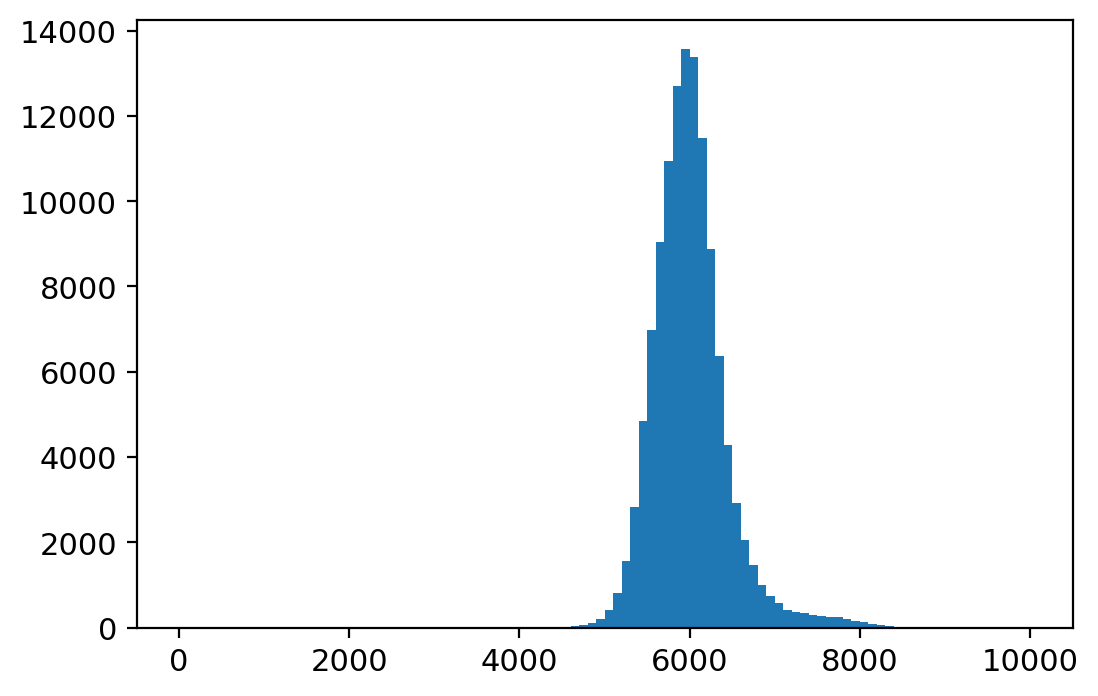

In [41]:
plt.hist(adata_atac.X.sum(1), bins=100, range=(0, 10000));

### 3.5 Find shared cells between RNA & ATAC

In [42]:
adata_rna.obs["orig.ident"].value_counts()

orig.ident
EarlyMale5          10205
LateFemale4          9849
EarlyFemale5         9314
EarlyCtrlMale5       7965
EarlyCtrlFemale5     7904
LateCtrl2            7390
EarlyCtrl4           6655
Late5                6161
LateCtrl3            5417
LateMale4            4855
Late1                4445
Late3                3928
PeakFemale4          3730
Peak5                3701
Early1               3609
EarlyMale3           3398
PeakMale4            3261
EarlyFemale3         3168
EarlyCtrl3           3109
Peak3                3083
PeakCtrl2            2703
PeakCtrl3            1812
Peak2                1473
Late2                1467
Early4               1243
EarlyCtrl2            338
Name: count, dtype: int64

In [43]:
adata_rna.obs["cellType_OL"].value_counts()

cellType_OL
MOL56-β    37969
MOL2-α     10854
MOL56-κ    10704
MOL2-β      8988
MOL2-ε      8413
MOL56-ζ     6299
MOL2-δ      6227
MOL56-γ     5595
MOL56-ε     4733
MOL56-α     4706
MOL56-δ     4166
MOL56-θ     3392
OPC-α       2134
MOL2-γ      1841
MOL56-ι     1093
OPC-γ       1072
COP         1002
MOL1         542
OPC-β        289
MOL56-η      164
Name: count, dtype: int64

In [44]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
print(len(shared_cells), len(shared_genes))

120183 798


In [45]:
# We reload in the raw data and continue with a subset of cells.
adata_rna = adata_Early1_rna.concatenate(adata_PeakCtrl2_rna,adata_Peak2_rna,adata_LateCtrl1_rna,adata_Late1_rna,adata_Early2_rna,adata_EarlyCtrl2_rna,adata_Peak3_rna,adata_PeakCtrl3_rna,adata_EarlyCtrl3_rna,adata_EarlyFemale3_rna,adata_EarlyMale3_rna,adata_Late2_rna,adata_LateCtrl2_rna,adata_Late3_rna,adata_LateCtrl3_rna,adata_PeakMale4_rna,adata_PeakFemale4_rna,adata_LateMale4_rna,adata_LateFemale4_rna,adata_Peak5_rna,adata_Late5_rna,adata_Naive3_rna,adata_EarlyCtrl4_rna,adata_EarlyCtrlMale5_rna,adata_EarlyCtrlFemale5_rna,adata_Early4_rna,adata_EarlyMale5_rna,adata_EarlyFemale5_rna,adata_Naive1_rna,adata_Naive2_rna, index_unique=None)

In [46]:
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

### 3.6 Normalization

In [47]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)

Normalized count data: X, spliced, unspliced.


/tmp/ipykernel_30882/2658231403.py:2: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


### 3.7 Find neighbors

In [48]:
sc.pp.pca(adata_rna)
sc.pp.neighbors(adata_rna, n_pcs=30, n_neighbors=30)

In [49]:
scv.pp.moments(adata_rna, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### 3.8 Recreate the annotation

In [50]:
adata_rna.obs['cellType_OL_merge'] = cell_annot.loc[adata_rna.obs_names, 'cellType_OL_merge']
adata_rna.obs['cellType_OL_merge'] = adata_rna.obs['cellType_OL_merge'].astype('category')
adata_rna.obs['cellType_OL'] = cell_annot.loc[adata_rna.obs_names, 'cellType_OL']
adata_rna.obs['cellType_OL'] = adata_rna.obs['cellType_OL'].astype('category')
adata_rna.obs['orig.ident_merge'] = cell_annot.loc[adata_rna.obs_names, 'orig.ident_merge']
adata_rna.obs['orig.ident_merge'] = adata_rna.obs['orig.ident_merge'].astype('category')
adata_rna.obs['orig.ident'] = cell_annot.loc[adata_rna.obs_names, 'orig.ident']
adata_rna.obs['orig.ident'] = adata_rna.obs['orig.ident'].astype('category')
adata_rna.obs['model'] = cell_annot.loc[adata_rna.obs_names, 'model']
adata_rna.obs['model'] = adata_rna.obs['model'].astype('category')

In [51]:
# Reorder the categories for color consistency with the manuscript.
all_clusters = ['OPC', 'COP', 'MOL56', 'MOL2', 'MOL1']
adata_rna.obs['cellType_OL_merge'] = adata_rna.obs['cellType_OL_merge'].cat.reorder_categories(all_clusters)

### 3.9 Cell projection in 2D

In [52]:
scv.tl.umap(adata_rna)

/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and wi

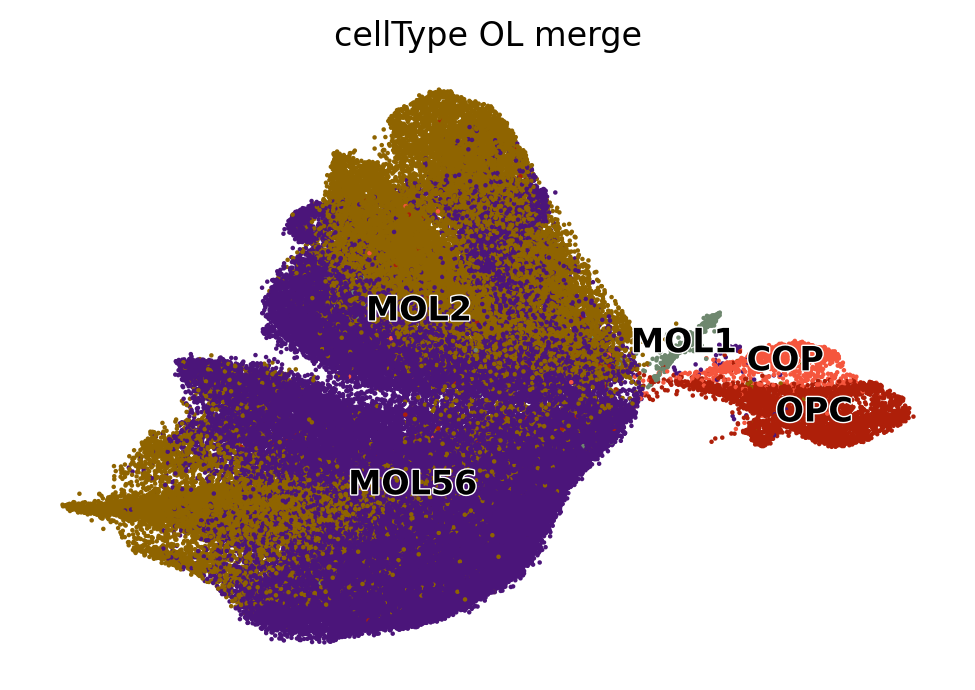

In [53]:
scv.pl.umap(adata_rna, color='cellType_OL_merge', palette=cellType_OL_merge_colors)

/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and wi

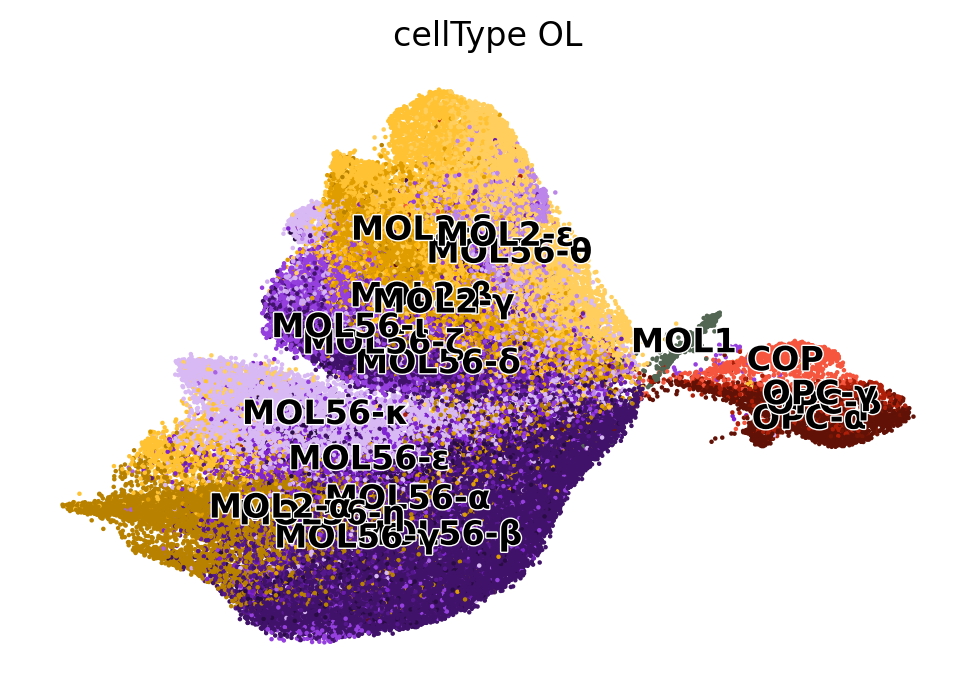

In [54]:
scv.pl.umap(adata_rna, color='cellType_OL', palette=cellType_OL_colors)

/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and wi

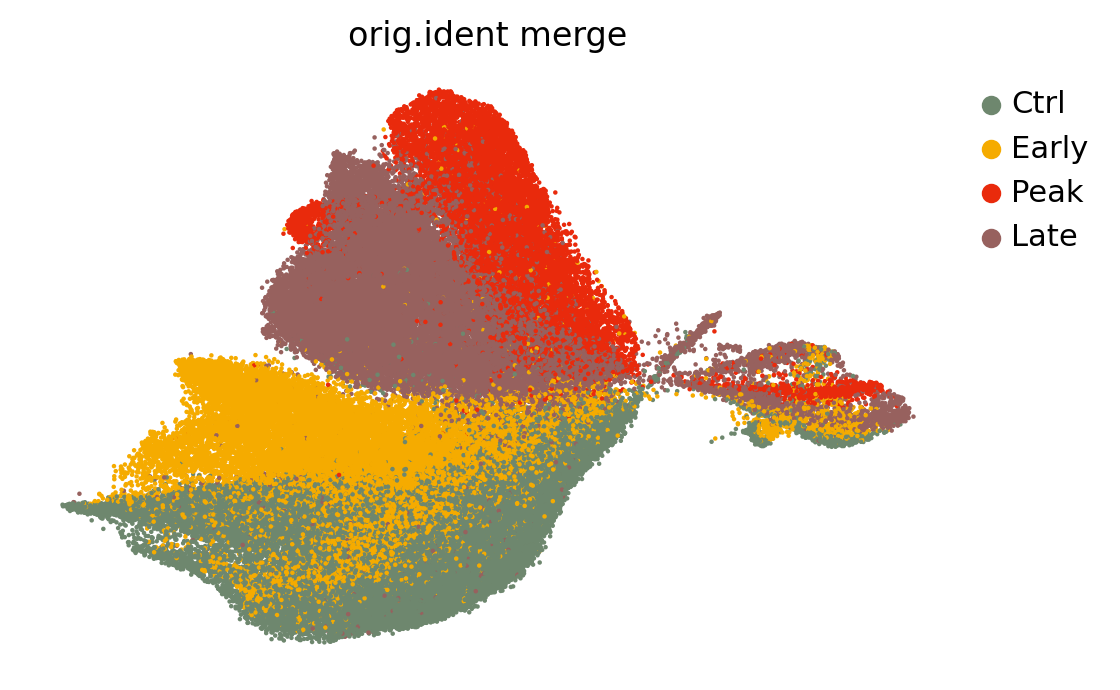

In [55]:
scv.pl.umap(adata_rna, color='orig.ident_merge', palette=orig_ident_merge_colors)

### 3.10 Extract Seurat graphs coordinates

In [58]:
nn_idx <- MORNAATACCOL$weighted.nn_OL@nn.idx
nn_dist <- MORNAATACCOL$weighted.nn_OL@nn.dist
nn_cells <- MORNAATACCOL$weighted.nn_OL@cell.names

In [59]:
%put nn_idx nn_dist nn_cells

In [60]:
%get nn_idx nn_dist nn_cells

indexes_not_present = [index for index, element in enumerate(nn_cells) if element not in adata_atac.obs.index.tolist()]
len(indexes_not_present)

indexes_order = [nn_cells.index(adata_atac.obs.index.tolist()[i]) for i in range(len(adata_atac.obs.index.tolist()))]

nn_cells_sorted = [nn_cells[i] for i in indexes_order]
nn_idx_sorted = np.array(nn_idx)[indexes_order]
nn_dist_sorted = np.array(nn_dist)[indexes_order]

nn_cells_sorted == adata_atac.obs.index.tolist()

True

### 3.11 Smooth ATAC data

In [61]:
mv.knn_smooth_chrom(adata_atac, nn_idx_sorted, nn_dist_sorted)

### 3.12 Generating MultiVelo Ann Data for each cellType

#### 3.12.1 MOL56

In [11]:
tmp_adata_rna = adata_rna[adata_rna.obs["cellType_OL_merge"] == "MOL56"]
tmp_adata_atac = adata_atac[adata_atac.obs.index.isin(tmp_adata_rna.obs.index)]

In [ ]:
# This will take a while. Parallelization is high recommended.
tmp_adata_result = mv.recover_dynamics_chrom(tmp_adata_rna, 
                                         tmp_adata_atac, 
                                         max_iter=5, 
                                         init_mode="invert", 
                                         verbose=False, 
                                         plot=False, 
                                         parallel=True, 
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         extra_color_key='orig.ident_merge'
                                        )

[Save](#X.1-Savings)

#### 3.12.2 MOL2

In [14]:
tmp_adata_rna = adata_rna[adata_rna.obs["cellType_OL_merge"] == "MOL2"]
tmp_adata_atac = adata_atac[adata_atac.obs.index.isin(tmp_adata_rna.obs.index)]

In [ ]:
# This will take a while. Parallelization is high recommended.
tmp_adata_result = mv.recover_dynamics_chrom(tmp_adata_rna, 
                                         tmp_adata_atac, 
                                         max_iter=5, 
                                         init_mode="invert", 
                                         verbose=False, 
                                         plot=False, 
                                         parallel=True, 
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         extra_color_key='orig.ident_merge'
                                        )

#### 3.12.3 OPC

In [144]:
tmp_adata_rna = adata_rna[adata_rna.obs["cellType_OL_merge"] == "OPC"]
tmp_adata_atac = adata_atac[adata_atac.obs.index.isin(tmp_adata_rna.obs.index)]

In [ ]:
# This will take a while. Parallelization is high recommended.
tmp_adata_result = mv.recover_dynamics_chrom(tmp_adata_rna, 
                                         tmp_adata_atac, 
                                         max_iter=5, 
                                         init_mode="invert", 
                                         verbose=False, 
                                         plot=False, 
                                         parallel=True, 
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         extra_color_key='orig.ident_merge'
                                        )

[Save](#X.1-Savings)

## X. Checkpoints

### X.1 Savings

In [6]:
#2
From notebook MORNAATACCOL
MORNAATACCOL <- readRDS(paste0(OS_path_outputs, "MORNAATACCOL.rds"))

In [66]:
%expand

adata_rna.write("{OS_path_outputs}"+"adata_rna.h5ad")
adata_atac.write("{OS_path_outputs}"+"adata_atac.h5ad")

In [143]:
%expand

adata_rna = sc.read_h5ad("{OS_path_outputs}"+"adata_rna.h5ad")
adata_atac = sc.read_h5ad("{OS_path_outputs}"+"adata_atac.h5ad")

In [13]:
%expand

#3.12.1
tmp_adata_result.write("{OS_path_outputs}"+"multivelo_MOL56.h5ad")

In [ ]:
%expand

#3.12.2
tmp_adata_result.write("{OS_path_outputs}"+"multivelo_MOL2.h5ad")

In [147]:
%expand

#3.12.3
tmp_adata_result.write("{OS_path_outputs}"+"multivelo_OPC.h5ad")